In [4]:
import pandas as pd
import numpy as np

In [2]:
datasets_path = lambda  file_name: f'/Users/stijnvanleeuwen/Desktop/codes/EUR/Ass2/datasets/{file_name}.parquet'

baskets = pd.read_parquet(datasets_path('baskets')).astype({'week':'uint8', 'customer':'uint','product':'category', 'price':'uint16'}) 
coupons = pd.read_parquet(datasets_path('coupons')).astype({'week':'uint8', 'customer':'uint','product':'category', 'discount':'uint8'})
prediction_index = pd.read_parquet(datasets_path('prediction_index')).astype({'week':'uint8', 'customer':'category','product':'category'}) 

In [3]:
baskets = baskets[baskets['customer']<2000].astype({'customer':'category'})
coupons = coupons[coupons['customer']<2000].astype({'customer':'category'})

# Creating base

In [131]:
weeks = range(0,88+1)
customers = range(1900,2000)
products = range(250)

n_weeks, n_customers, n_products = len(weeks), len(customers), len(products)

base = pd.DataFrame({
    'week': np.array([[x] * n_products * n_customers for x in weeks]).flatten(),
    'customer': np.array([[x] * n_products for x in customers] * n_weeks).flatten(),
    'product': list(range(n_products)) * n_customers * n_weeks
})

#Creating basket id
base['basket'] = base['week'].astype(str) + '_' +base['customer'].astype(str)

#Adding basket information
base = pd.merge(base, baskets, on=['week', 'customer','product'], how='left')
base['price'] = base['price'].fillna(0).astype(int)
base['isBought'] = (base['price'] > 0)

#Adding coupon information
base = pd.merge(base, coupons, on=['week', 'customer','product'], how='left')
base['discount'] = base['discount'].fillna(0).astype(int)
base = base.rename(columns={"discount": "dGiven"})
base['isGiven'] = (base['dGiven'] > 0)

normal_prices = baskets.groupby('product')['price'].max().values
base['highestPrice'] = base['product'].apply(lambda x: normal_prices[x])
base['isUsed'] = ((base['price'] != base['highestPrice']) & (base['price']!=0))
base.drop('highestPrice', axis=1, inplace=True)

In [138]:
pd.set_option('max_rows',250)

per product kijk je hoe vaak dat in baskets met andere producten voorkomt
       bask
       1    2   3
prod 1 0
     2 3
     3 3

In [150]:
base

,week,customer,product,basket,price,isBought,dGiven,isGiven,isUsed
0,0,1900,0,0_1900,0,0,0,False,False
1,0,1900,1,0_1900,0,0,0,False,False
2,0,1900,2,0_1900,0,0,0,False,False
3,0,1900,3,0_1900,0,0,0,False,False
4,0,1900,4,0_1900,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
2224995,88,1999,245,88_1999,0,0,0,False,False
2224996,88,1999,246,88_1999,0,0,0,False,False
2224997,88,1999,247,88_1999,0,0,0,False,False
2224998,88,1999,248,88_1999,0,0,0,False,False


In [151]:
base.basket.nunique()

8900

In [ ]:
matrix = base.iloc[0:0+250, 5].values
for i in range(1,base.basket.nunique()):
    start = i*250
    matrix = np.vstack((matrix, base.iloc[i:i+250, 5].values))

In [212]:
co_df = pd.DataFrame(matrix)

In [243]:
co_df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8896,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8897,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8898,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)})

<AxesSubplot:>

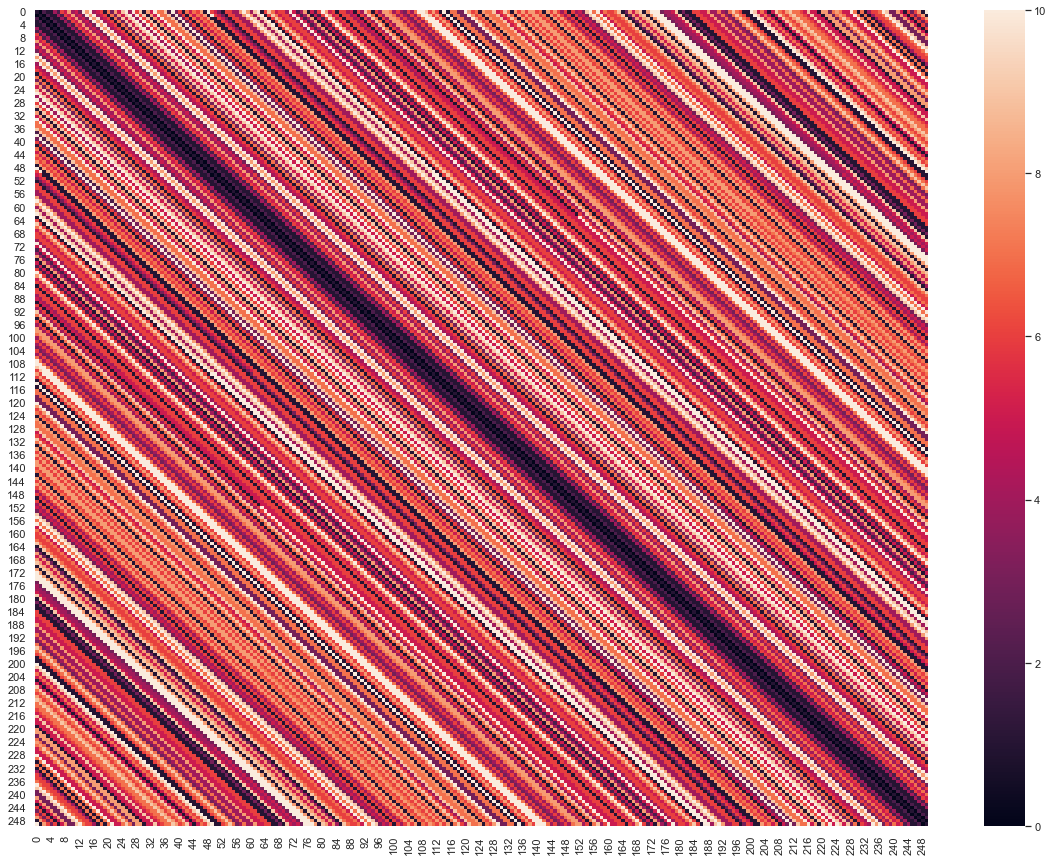

In [282]:
co_matrix = co_df.T.dot(co_df)
co_matrix[co_matrix > 10] = 1
sns.heatmap(co_matrix, annot=False)